# Comparison with Dieter's results


In [1]:
import sys
sys.path.append('/home/hpc/caph/mppi086h/woody/software/crabmeyerpy')
sys.path.append('/home/hpc/caph/mppi086h/woody/software/fast_interp')

In [2]:
from crabmeyerpy.ssc import kpc2cm, m_e_eV, arcmin2rad, eV2erg, eV2Hz, CrabSSC
from crabmeyerpy.ssc_3d import CrabSSC3D
from crabmeyerpy.electrondensity import (
    nel_crab,
    nel_crab_extension,
    electron_distribution_width_bpl,
    electron_distribution_width_bpl_smooth
)
from crabmeyerpy.photonfields import black_body, j_dust_carbon_shell, j_grey_body_shell, j_grey_body_gauss
from crabmeyerpy.data import CrabData
from scipy.integrate import simps, romb
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy
import astropy.constants as c
from astropy import constants
import astropy.units as u
import time

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#The magnetic field strength and the distance to the nebula
d = 2.  # distance to nebula in kpc

# 3D model

Next we initialize the 3D model

In [5]:
# config with Dieter's best fit parameters
# Beware Nradio and Nwind are mutliplied with 4pi
# divide by 4pi for exact copy of Dieter's results

# if we multiply Nwind with 1.3 then the results match very well ... 
config = {
 'Nradio': 8.180633538148642e+50 / 4. / np.pi,
 'gradio_min': 22.0,
 'gradio_max': 89321.72336080558,
 'Sradio': -1.54,
 'Nwind': 1.4130015182175857e+33 / 4. / np.pi * 1.3,
 'gmin': 22.0,
 'gmax': 72004899337.38588,
 'gwind_min': 327747.9018738116,
 'gwind_max': 4839126179.743089,
 'gwind_b': 7.519317344265103e-09,
 'Swind': -2.950271909957147,
 'Sbreak': -0.23070987949414531,
 'sup_wind': 2.8,
 'radio_size_cm': 2.662842263714745e+18,
 'index': 0.15,
 'dust_T1': 149,
 'dust_T2': 39,
 'log10_M1': -4.4,
 'log10_M2': -1.2,
 'abs_norm': 21500.0,
 'abs_index': 1.3,
 'r_min': 1.6971226698202522e+18,
 'r_max': 4.721086699681792e+18,
 'ic_sync': 1.0,
 'ic_dust': 1.0,
 'ic_cmb': 1.0,
 'B0': 0.000264,
 'B_r0': 4.01e+17,
 'B_index': -0.51,
 'wind_size_cm': 2.96e+18,
 'gwind_b2': 4.733181315119607e-07,
 'Sbreak2': 1.1877496095861664,
 'e_scale': 1.0,
 'S1': -3.1,
 'S2': -3.45,
 'S3': -3.77,
 'gwind_1': 5956538.013184614,
 'gwind_2': 217998774.6792103}

In [6]:
print("Break energy of wind spectrum {0:e}eV".format(1. / config['gwind_b'] * m_e_eV))

Break energy of wind spectrum 6.795816e+13eV


In [7]:
# maximum radius of nebula
# This number should probably be updated to newer values
# it comes from Atoyan & Aharonian 1996
r0_pc = 1.8
r0_pc = 3.

In [8]:
# Dieter's electron spectra
def nel_crab_wind(gamma, **params):
    result = np.zeros(gamma.shape)
    m_wind = (gamma > params['gwind_min']) & (gamma <= params['gwind_max']) # min - max
    m_wind_br1 = (gamma > params['gwind_min']) & (gamma <= params['gwind_1']) # min - b1
    m_wind_br2 = (gamma > params['gwind_1']) & (gamma <= params['gwind_2']) # b1 - b2
    m_wind_br3 = (gamma > params['gwind_2']) & (gamma <= params['gwind_max']) # b2 - max
    
    result[m_wind_br1] += np.power(gamma[m_wind_br1] / params['gwind_1'], params['S1']) \
                        * np.power(params['gwind_1'] / params['gwind_2'], params['S2'])
    result[m_wind_br2] += np.power(gamma[m_wind_br2] / params['gwind_2'], params['S2'])
    result[m_wind_br3] += np.power(gamma[m_wind_br3] / params['gwind_2'], params['S3'])
    result[m_wind] *= params['Nwind']
       
    return result

def nel_crab_extension(r, gamma, **params):
    rho = electron_distribution_width_simple_PL(gamma, **params)  
    result = np.exp(-r ** 2. / rho ** 2. / 2.) / rho**3        
    return result

def nel_crab_radio(gamma, **params):
    result = np.zeros(gamma.shape)
    m_radio = (gamma > params['gradio_min']) & (gamma < params['gradio_max'])
    result[m_radio] += np.power(gamma[m_radio], params['Sradio']) * params['Nradio']
    return result

def nel_radio_extension_gauss(r, **params):
    result = np.exp(-r**2. / 2. / params['radio_size_cm']**2) / params['radio_size_cm']**3
    return result

def nel_spec_separate(gamma, r, **params):
    result = nel_crab_radio(gamma, **params) * nel_radio_extension_gauss(r, **params)
    result += nel_crab_wind(gamma, **params) * nel_crab_extension(r, gamma, **params)
    return result

In [9]:
# Dieter's extension
def electron_distribution_width_simple_PL(gamma, **params):
    """
    Calculate the energy-dependent width of the electron distribution


    Parameters
    ----------
    gamma: array-like
        gamma values

    params: dict
        dict with parameters

    Returns
    -------
    Width of electron distribution as a function of gamma
    """

#     return params['wind_size_cm'] * (gamma/params['gradio_max'])**params['index']
#     return params['wind_size_cm'] * gamma**params['index']

    # Dieter's implementation eq. (5)
    # 
    prefactor = params['wind_size_cm']#/3600 *np.pi/180 *6.171355162982735e+21 # * d_crab/2kpc (= 1)
    base = np.power(gamma/9e5,2)   # * B_0/264 (=1)
    return prefactor * np.power(base, -params['index'])

In [10]:
# Dieter's B field function
def vary_B(r, **params):
    return params['B0'] * np.power(r / params['B_r0'], params['B_index'])

Initialize the model

In [11]:
ssc = CrabSSC3D(copy.deepcopy(config),
                nel_spec_separate,
                vary_B,
                j_dust_carbon_shell,
                d_kpc=d,
                r0_pc=r0_pc,
                r_shock_pc=config['B_r0'] / kpc2cm * 1e3,
                log_level="DEBUG", 
                ic_sync=True, ic_cmb=True, ic_dust=True)

In [13]:
print(config['B_r0'] / kpc2cm * 1e3, ssc._r_shock)

0.12995524950671902 4.0099999999999994e+17


In [14]:
# wind extension from dieter's paper Eq. 5
print(99.4 / 3600 * np.pi / 180 * ssc.d)  # this is how Tim does it
print(99.4 / 3600 * np.pi / 180 * kpc2cm)
#ssc.parameters['wind_size_cm'] = 99.4 / 3600 * np.pi / 180 * kpc2cm  # let's check this; nope does not work
# radio extension
print(89.4 / 3600 * np.pi / 180 * ssc.d)

2.974005669516e+18
1.487002834758e+18
2.6748099281160003e+18


## plot the electron density at different radii

In [15]:
r = np.linspace(config['B_r0'], ssc.r0, 9)
gamma = np.logspace(0., 10., 100)

gg, rr = np.meshgrid(gamma, r, indexing='ij')

r_dieter = np.insert(np.arange(0.5, 3.5, 0.5), 0, 0.14) * kpc2cm * 1e-3
ggd, rrd = np.meshgrid(gamma, r_dieter, indexing='ij')

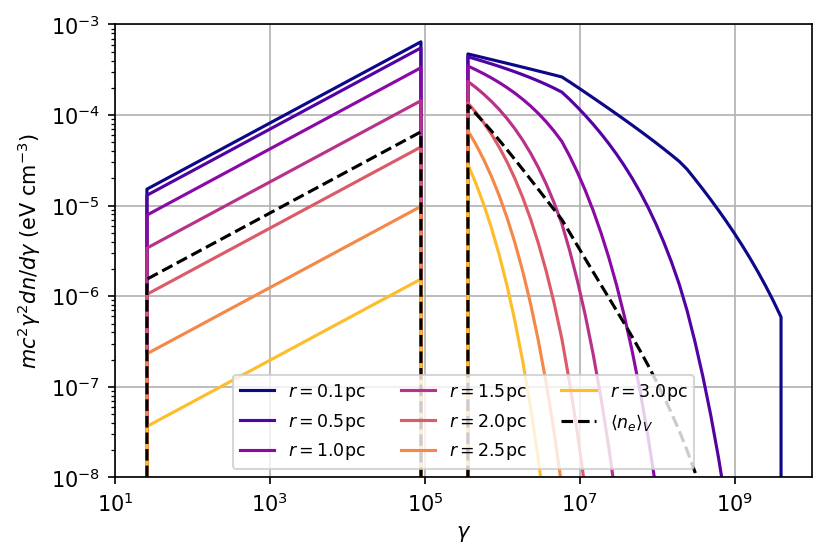

In [16]:
plt.figure(dpi=150)

c = gamma**2. #* m_e_eV

# compute n_el over grid of gamma and r
n_el = ssc.n_el(gg, rr, **ssc.parameters)
n_el_d = ssc.n_el(ggd, rrd, **ssc.parameters)

# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
n_el_avg = 4. * np.pi * simps(n_el * rr ** 2., rr) / V0

for i, ri in enumerate(r_dieter):
    plt.loglog(gamma, n_el_d[:,i] * c,
               color=plt.cm.plasma(i/r_dieter.size),
               label='$r={0:.1f}$pc'.format(ri / kpc2cm * 1e3)
              )
    
plt.loglog(gamma, n_el_avg * c, ls='--', color='k',  label=r'$\langle n_e \rangle_V$')
plt.legend(fontsize='small', ncol=3)
v = plt.gca().get_ylim()
vx = plt.gca().get_xlim()
#plt.ylim(v[1]/1e7, v[1])
#plt.ylim(v[1]/1e7, v[1])
plt.ylim(1e-8, 1e-3)
plt.xlim(10.,1e10)
plt.xlabel("$\gamma$")
plt.ylabel("$ mc^2 \gamma^2 dn/d\gamma $ (eV cm$^{-3}$)")
plt.gca().grid(True)

Plot the energy dependent width of the Gaussian for the spatial distribution of the electrons. 

Text(0.5, 0, '$\\gamma$')

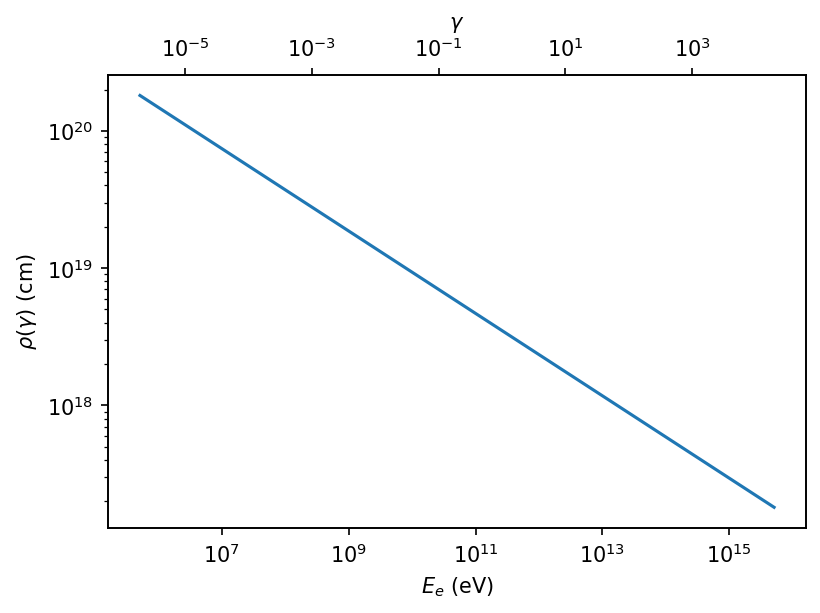

In [17]:
plt.figure(dpi=150)
plt.loglog(gamma * m_e_eV, electron_distribution_width_simple_PL(gamma, **config))
plt.xlabel("$E_e$ (eV)")
plt.ylabel(r"$\rho(\gamma)$ (cm)")

ax2 = plt.gca().twiny()
ax2.set_xlim(vx[0] / m_e_eV, vx[1] / m_e_eV)
ax2.set_xscale("log")
ax2.set_xlabel("$\gamma$")

## Calculate the Synchrotron and Dust emissivities

Cacluate the volume emissivity $j_\nu^\mathrm{sync}(\nu, r)$ in units of $\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$.
From it, you can calculate the the luminosity as a volume integral, as well as the specific intensity as a l.o.s. integral. 
From the specific intensity, you get the flux by integrating over solid angle.

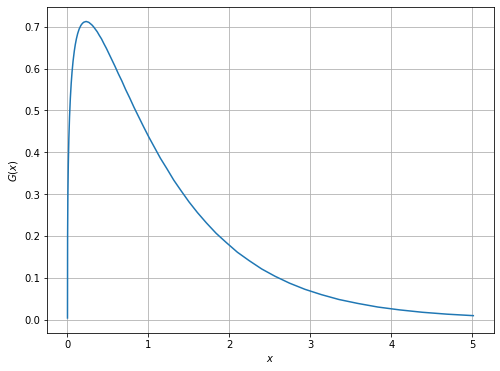

In [18]:
# first check G(x) function from https://arxiv.org/pdf/1006.1045.pdf Fig. 13
plt.figure(figsize=(8,6))
x = np.logspace(-8., 0.7, 300)
plt.plot(x, np.exp(ssc.log_xF(np.log(x))))
plt.xlabel("$x$")
plt.ylabel("$G(x)$")
plt.grid()

In [19]:
#ssc.r0 = 3. * 1e-3 * kpc2cm
nu = np.logspace(7.,25.,500)
r = np.linspace(config['B_r0'], ssc.r0, 2**7 + 1)
nn, rr = np.meshgrid(nu, r, indexing='ij')

In [20]:
j_nu_sync = ssc.j_sync(nu, r, g_axis=2, g_steps=2**9+1, integration_mode='romb')
print(j_nu_sync.shape)

(500, 129)


Cacluate the volume emissivity $j_\nu^\mathrm{dust}(\nu, r)$ in units of $\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$

In [21]:
j_nu_dust = ssc.j_dust_nebula(nu, r)
print(j_nu_dust.shape)
print(j_nu_dust.min())
print(j_nu_dust.max())
volume = 4. / 3. * np.pi * (ssc.parameters['r_max']**3. - ssc.parameters['r_min']**3.)
print(j_nu_dust.max())
print(volume)
print(np.any(np.isnan(j_nu_dust)))

/home/hpc/caph/mppi086h/woody/software/crabmeyerpy/crabmeyerpy/photonfields.py:44: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 484 --- DEBUG: Dust calculation in j_dust_nebula function took 0.011s


(500, 129)
0.0
1.7374524464453113e-34
1.7374524464453113e-34
4.202973396774586e+56
False


Plot the volume emissivity

(1e-25, 1e-18)

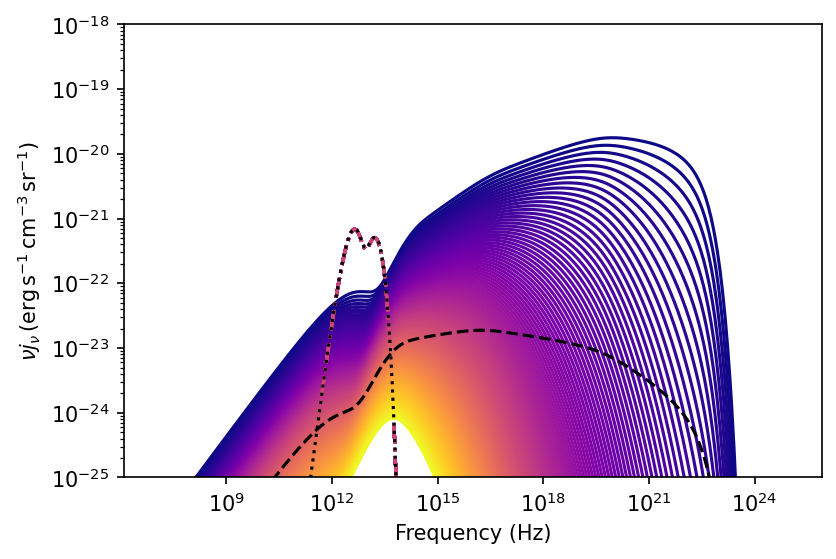

In [22]:
plt.figure(dpi=150)

for i, ri in enumerate(r):
    plt.loglog(nu, j_nu_sync[:,i] * nu,
               color=plt.cm.plasma(i/r.size),
               label='$r={0:.1f}$pc'.format(ri / kpc2cm * 1e3)
              )
    plt.loglog(nu, j_nu_dust[:,i] * nu,
               color=plt.cm.plasma(i/r.size),
               ls='-.'
              )
    
# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
Vdust = 4. / 3. * np.pi * (ssc.parameters['r_max']**3. - ssc.parameters['r_min']**3.)

j_nu_sync_avg = 4. * np.pi * simps(j_nu_sync * rr ** 2., rr) / V0
j_nu_dust_avg = 4. * np.pi * simps(j_nu_dust * rr ** 2., rr) / Vdust

plt.loglog(nu, j_nu_sync_avg * nu,
           color='k',
           ls='--',
           label=r'$\langle j_\nu^\mathrm{sync} \rangle_V$'
           )

plt.loglog(nu, j_nu_dust_avg * nu,
           color='k',
           ls=':',
           label=r'$\langle j_\nu^\mathrm{dust} \rangle_V$'
           )

#plt.legend(fontsize='small', ncol=3)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu j_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$)")
plt.ylim(1e-25, 1e-18)

Calculate and plot the luminosity

In [23]:
# one factor of 4 pi from volume integral, second one from integral over 
# the solid angle. Each volume element emits isotropically.
L_nu_sync = romb(j_nu_sync * rr **2., dx=np.diff(r)[0], axis=1) * 4. * np.pi * 4. * np.pi
L_nu_dust = romb(j_nu_dust * rr **2., dx=np.diff(r)[0], axis=1) * 4. * np.pi * 4. * np.pi

In [24]:
sync = np.genfromtxt('sed_Sat_Feb_12_19_06_03_2022_6.dat.txt')
sync_all = np.sum(sync[:,1:3],axis=1)
dust = sync[:,3]

(1e+33, 1e+38)

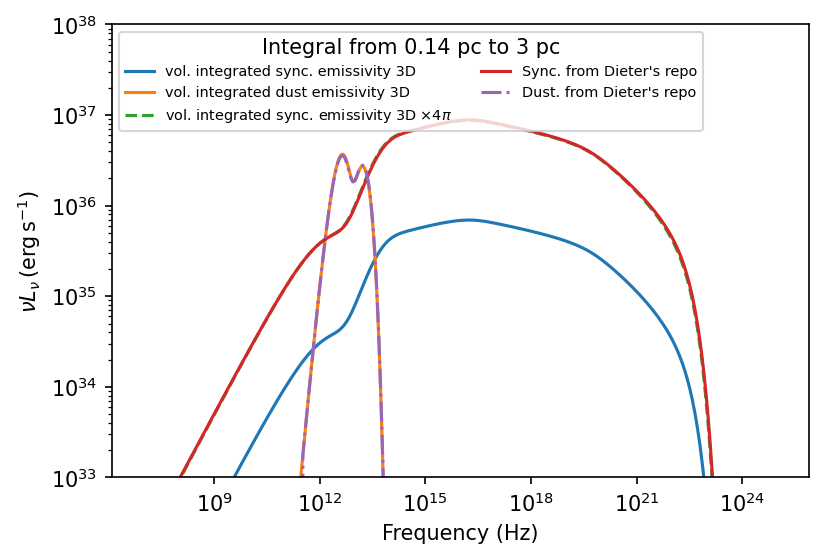

In [25]:
fig = plt.figure(dpi=150)
plt.loglog(nu, nu * L_nu_sync, label="vol. integrated sync. emissivity 3D")
plt.loglog(nu, nu * L_nu_dust, label="vol. integrated dust emissivity 3D")

plt.loglog(nu, nu * L_nu_sync * 4. * np.pi,
           label=r"vol. integrated sync. emissivity 3D $\times 4\pi$", ls='--')

plt.loglog(sync[:, 0] / constants.h.to('eV s'),
           sync_all * sync[:, 0] / constants.h.to('eV s') * 1e7,
           label="Sync. from Dieter's repo")

plt.loglog(sync[:, 0] / constants.h.to('eV s'),
           dust * sync[:, 0] / constants.h.to('eV s') * 1e7,
           label="Dust. from Dieter's repo", ls='-.')

# plot the 1D spectrum for comparison
#plot_1d(fig=fig, ic=False)
plt.legend(fontsize='x-small', title="Integral from 0.14 pc to 3 pc", ncol=2, loc=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.ylim(1e33, 1e38)
#plt.ylim(1e23, 1e38)

In [32]:
I_nu_sync, theta_arcmin_sync, _ = ssc.intensity(nu,
                                                theta=2**7+1,
                                                which='sync',
                                                integration_mode='romb',
                                                r_steps=2**6+1)

In [33]:
2**6+1,2**7+1

(65, 129)

Text(0, 0.5, '$\\nu I_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}\\,\\mathrm{sr}^{-1}$)')

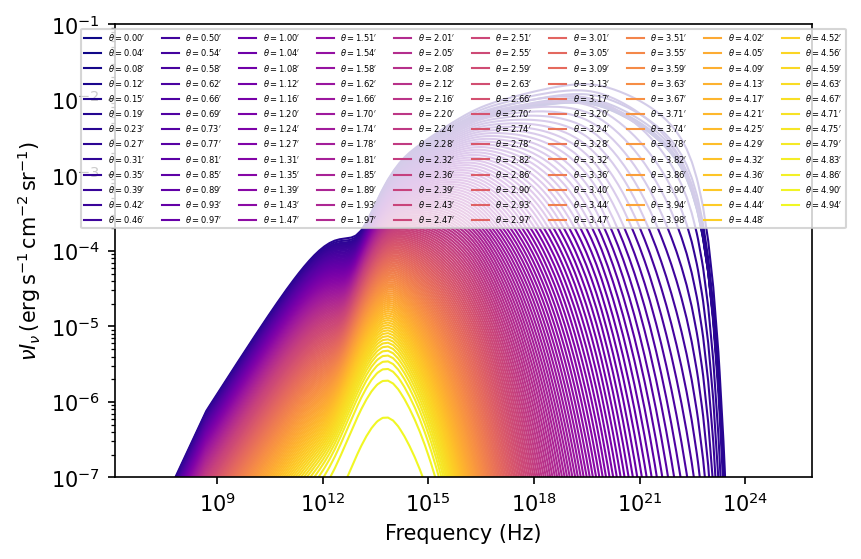

In [34]:
plt.figure(dpi=150)

for i, t in enumerate(theta_arcmin_sync):
    plt.loglog(nu, I_nu_sync[:,i] * nu,
               color=plt.cm.plasma(i / float(theta_arcmin_sync.size)),
               label=r"$\theta={0:.2f}^\prime$".format(t),
               lw=1
              )

    
plt.legend(ncol=10, fontsize=4, loc=9)
plt.ylim(1e-7, 1e-1)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu I_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{sr}^{-1}$)")

In [35]:
theta_arcmin_min = np.rad2deg(np.arctan(ssc.parameters['B_r0'] / ssc.d)) * 60.
print(theta_arcmin_min)

0.22337661935476502


In [40]:
f_nu_sync = ssc.flux(nu, 
                   which='sync',
                   integration_mode='romb',
                   r_steps=2**7+1,
                   theta_steps=2**8+1)

In [43]:
theta_arcmin_min, theta_arcmin_sync[-1]

(0.22337661935476502, 4.94164446553332)

(1000000000.0, 2e+23)

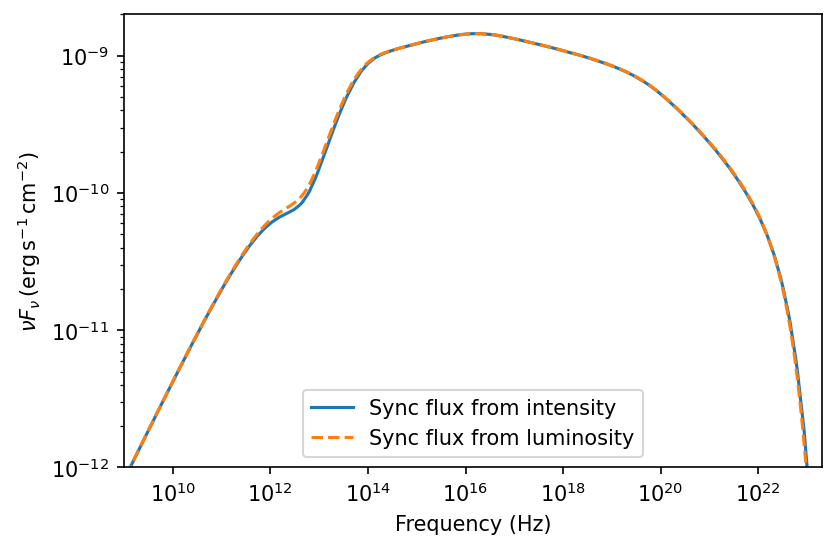

In [41]:
plt.figure(dpi=150)
plt.loglog(nu, nu * f_nu_sync, label="Sync flux from intensity")
plt.loglog(nu, nu * L_nu_sync / 4. / np.pi / ssc.d**2.,
           label="Sync flux from luminosity", ls='--')

plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")
plt.ylim(1e-12, 2e-9)
plt.xlim(1e9, 2e23)

In [71]:
ssc._r_shock = 4e17

## IC component

Now we repeat the steps of calculating $j_\nu$, $I_\nu$, and $F_\nu$ for the IC component. 

In [72]:
# define nu and r arrays 
nu_ic = np.logspace(22., 30., 8 * 5 + 1)
r_ic_egdes = r

r_ic = 0.5 * (r_ic_egdes[1:] + r_ic_egdes[:-1])

nni, rri = np.meshgrid(nu_ic, r_ic, indexing='ij')

# set the steps used for the integration
# these numbers yielded relatively smooth spectra
# in my tests 
# the r1_steps needs to be of the shape 2**k + 1 since romb integration is used
g_steps = 2**8+1  # steps for integration over gamma
e_steps = 2**7+1  # steps for integration over energy of seed photon field
r1_steps = 2**7+1   # steps for integration over radius, see Atoyan & Aharonian (1996) Eq. 15

In [76]:
ssc.integration_mode = "numba_piecewise"  # fastest mode of integration
ssc.use_fast_interp = True  # fastest mode of interpolation; also used to interpolate the photon densities

#ssc.integration_mode = "romb"  # slowest mode of integration
#ssc.use_fast_interp = False  # slow mode of interpolation; also used to interpolate the photon densities


ssc.ic_sync = False
ssc.ic_dust = True
ssc.ic_cmb = False

t0 = time.time()
j_nu_ic_dust = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps, 
                   integration_mode='romb'
                  )
t1 = time.time()

print(f"This took {t1 - t0:.2f}s")

/home/hpc/caph/mppi086h/woody/software/crabmeyerpy/crabmeyerpy/photonfields.py:44: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 508 --- DEBUG: Dust calculation in j_dust_nebula function took 0.290s
 ssc_3d.py: 728 --- DEBUG: time to calculate grey body 0.302s  time for integration of dust component  0.071s
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function '_interp2d_k1'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../hpc/caph/mppi086h/woody/software/fast_interp/fast_interp/fast_interp.py", line 329:
@numba.njit(parallel=True)
def _interp2d_k1(f, xout, yout, fout, a, h, n, p, o, lb, ub):
^

  warnings.war

 ssc_3d.py: 886 --- DEBUG: kernel shape for integration over photon dens energy: (41, 257, 129, 128)
 ssc_3d.py: 896 --- DEBUG: kernel shape for integration over gamma factor: (41, 257, 128)
 ssc_3d.py: 913 --- DEBUG: integration over photon dens and gamma took 3.488s


This took 7.25s


In [77]:
ssc.integration_mode = "numba_piecewise"  # fastest mode of integration
ssc.use_fast_interp = True  # fastest mode of interpolation; also used to interpolate the photon densities

#ssc.integration_mode = "romb"  # slowest mode of integration
#ssc.use_fast_interp = False  # slow mode of interpolation; also used to interpolate the photon densities


ssc.ic_sync = False
ssc.ic_dust = False
ssc.ic_cmb = True

t0 = time.time()
j_nu_ic_cmb = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps, 
                   integration_mode='romb'
                  )
t1 = time.time()

print(f"This took {t1 - t0:.2f}s")

/home/hpc/caph/mppi086h/woody/software/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 886 --- DEBUG: kernel shape for integration over photon dens energy: (41, 257, 129, 128)
 ssc_3d.py: 896 --- DEBUG: kernel shape for integration over gamma factor: (41, 257, 128)
 ssc_3d.py: 913 --- DEBUG: integration over photon dens and gamma took 3.425s


This took 7.10s


In [78]:
ssc.integration_mode = "numba_piecewise"  # fastest mode of integration
ssc.use_fast_interp = True  # fastest mode of interpolation; also used to interpolate the photon densities

#ssc.integration_mode = "romb"  # slowest mode of integration
#ssc.use_fast_interp = False  # slow mode of interpolation; also used to interpolate the photon densities


ssc.ic_sync = True
ssc.ic_dust = False
ssc.ic_cmb = False

t0 = time.time()
j_nu_ic_sync = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps, 
                   integration_mode='romb'
                  )
t1 = time.time()

print(f"This took {t1 - t0:.2f}s")

 ssc_3d.py: 676 --- DEBUG: (129, 128, 129)
 ssc_3d.py: 677 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 687 --- DEBUG: phot_dens: time for interpolation of Sync: 0.155s, time for integration of SSC component  0.090s,  time for filling arrays 0.024s 
 ssc_3d.py: 886 --- DEBUG: kernel shape for integration over photon dens energy: (41, 257, 129, 128)
 ssc_3d.py: 896 --- DEBUG: kernel shape for integration over gamma factor: (41, 257, 128)
 ssc_3d.py: 913 --- DEBUG: integration over photon dens and gamma took 3.427s


This took 5.79s


(1e-27, 1e-22)

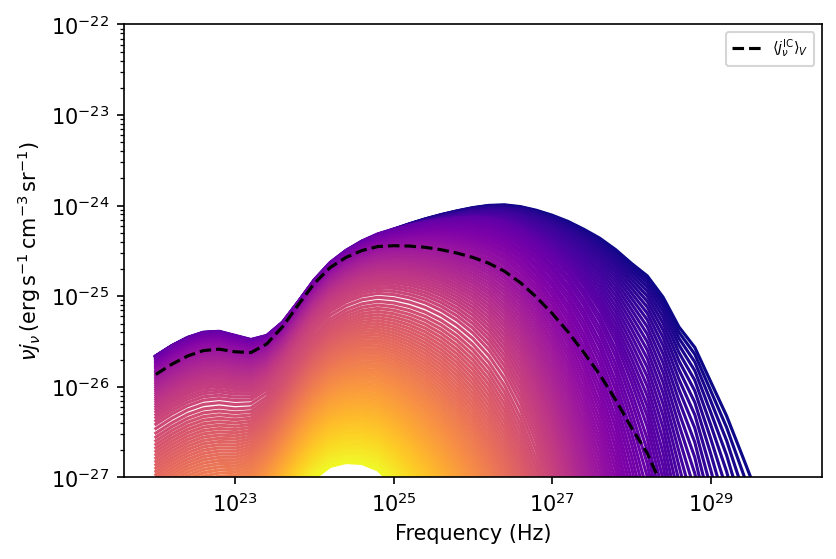

In [79]:
plt.figure(dpi=150)

for i, ri in enumerate(r_ic):
    plt.loglog(nu_ic, j_nu_ic_dust[:,i] * nu_ic,
               color=plt.cm.plasma(i/r_ic.size),
               #label='$r={0:.1f}$pc'.format(ri / kpc2cm * 1e3)
              )
   
j_nu_ic_avg = 4. * np.pi * simps(j_nu_ic_dust * rri ** 2. * rri, np.log(rri)) / Vdust

plt.loglog(nu_ic, j_nu_ic_avg * nu_ic,
           color='k',
           ls='--',
           label=r'$\langle j_\nu^\mathrm{IC} \rangle_V$'
           )

plt.legend(fontsize='x-small', ncol=3)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu j_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$)")
plt.ylim(1e-27, 1e-22)

In [80]:
# Calculate the luminosity
# one factor of 4 pi from volume integral, second one from integral over 
# the solid angle. Each volume element emits isotropically.
L_nu_ic_dust = simps(j_nu_ic_dust * rri **2., rri, axis=1) * 4. * np.pi * 4. * np.pi

L_nu_ic_cmb = simps(j_nu_ic_cmb * rri **2., rri, axis=1) * 4. * np.pi * 4. * np.pi

L_nu_ic_sync = simps(j_nu_ic_sync * rri **2., rri, axis=1) * 4. * np.pi * 4. * np.pi

In [81]:
# get Dieter's points
ic = np.genfromtxt('sed_IC_Sat_Feb_12_19_06_03_2022_6.dat.txt')
#sync_all = np.sum(sync[:,1:3],axis=1)
ic_dust = ic[:,2] + ic[:,5]
ic_cmb = ic[:,1] + ic[:,4]
ic_sync = ic[:,3] + ic[:,6]

(1e+30, 3e+35)

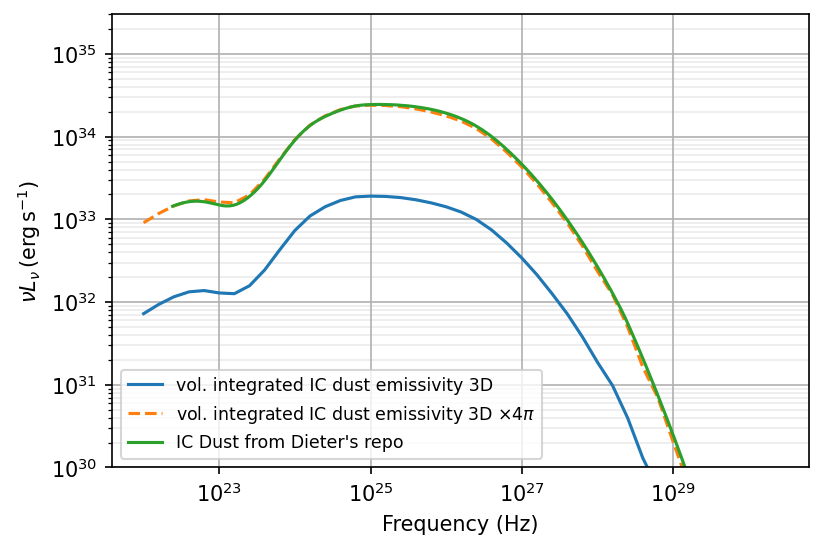

In [82]:
fig = plt.figure(dpi=150)
plt.loglog(nu_ic, nu_ic * L_nu_ic_dust, label="vol. integrated IC dust emissivity 3D")
plt.loglog(nu_ic, nu_ic * L_nu_ic_dust * 4. * np.pi,
           label=r"vol. integrated IC dust emissivity 3D $\times4\pi$", ls='--')

plt.loglog(ic[:, 0] / constants.h.to('eV s'),
           ic_dust * ic[:, 0] / constants.h.to('eV s') * 1e7,
           label="IC Dust from Dieter's repo")

plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.grid()
plt.grid(which='minor', lw=0.2)
plt.ylim(1e30, 3e35)

### Check integration bounds of r1 in this case. Should go from r_min_shell (r_min_dust) to r_max (r_max_dust)

(1e+30, 3e+35)

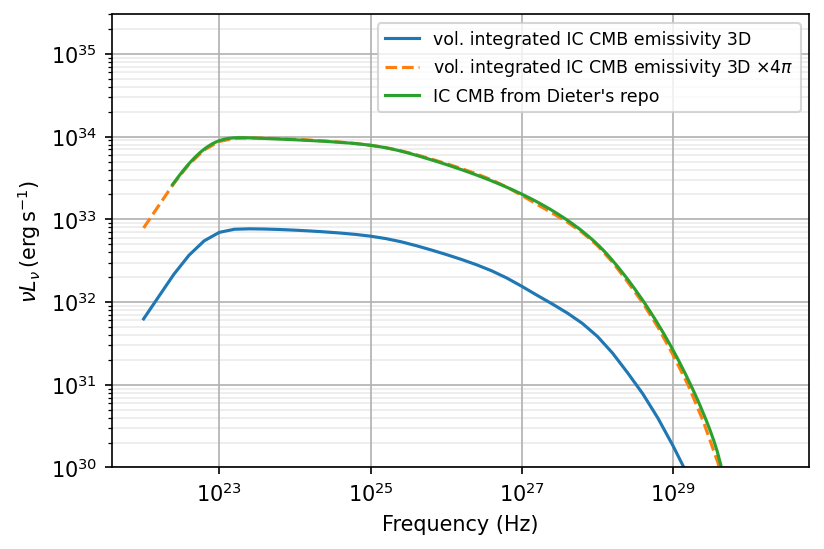

In [83]:
fig = plt.figure(dpi=150)
plt.loglog(nu_ic, nu_ic * L_nu_ic_cmb, label="vol. integrated IC CMB emissivity 3D")
plt.loglog(nu_ic, nu_ic * L_nu_ic_cmb * 4. * np.pi,
           label=r"vol. integrated IC CMB emissivity 3D $\times4\pi$", ls='--')

plt.loglog(ic[:, 0] / constants.h.to('eV s'),
           ic_cmb * ic[:, 0] / constants.h.to('eV s') * 1e7,
           label="IC CMB from Dieter's repo")

plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.grid()
plt.grid(which='minor', lw=0.2)
plt.ylim(1e30, 3e35)

### Check integration bounds of r1 in this case. Should go from 0 to r_max

(1e+30, 3e+35)

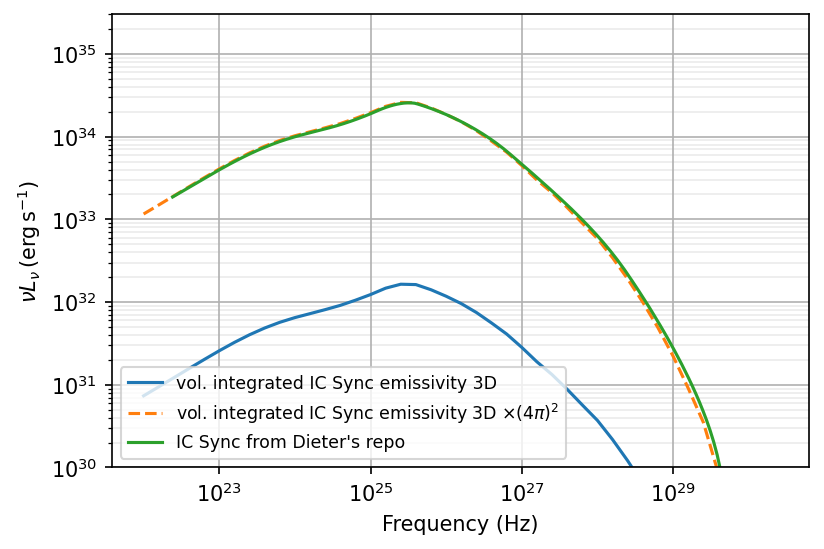

In [84]:
fig = plt.figure(dpi=150)
plt.loglog(nu_ic, nu_ic * L_nu_ic_sync, label="vol. integrated IC Sync emissivity 3D")
plt.loglog(nu_ic, nu_ic * L_nu_ic_sync * (4. * np.pi)**2.,
           label=r"vol. integrated IC Sync emissivity 3D $\times(4\pi)^2$", ls='--')

plt.loglog(ic[:, 0] / constants.h.to('eV s'),
           ic_sync * ic[:, 0] / constants.h.to('eV s') * 1e7,
           label="IC Sync from Dieter's repo")

plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.grid()
plt.grid(which='minor', lw=0.2)
plt.ylim(1e30, 3e35)

### Check integration bounds of r1 in this case. Should go from 0 to r_max